# **Task 2: Visualizing Attention and Analyzing the “Attention Sink” Phenomenon**

## **Overview**
Explores **Transformer self-attention** by capturing, visualizing, and quantifying attention maps, then simulates how **StreamLLM** leverages the *“attention sink”* to enable long-sequence generation with fixed memory.  
The notebook adds `output_attentions=True` for introspection, builds a hook-based **Attention Catcher**, measures sink attention across layers, and contrasts standard **KV caching** with a **StreamLLM-style cache** that trims middle tokens while preserving sinks and recency.

---

## **Step 1: Load the Model in Investigation Mode (Cell 4)**

- **Enable attention outputs:**  
  Load the model with  
  `AutoModelForCausalLM.from_pretrained(..., output_attentions=True)`  
  so each forward pass returns per-layer attention tensors alongside logits.

- **Tokenization setup:**  
  Initialize the matching `AutoTokenizer` and standard generation configs used throughout experiments.

---

## **Step 2: Build the “Attention Catcher” Toolkit (Cell 5)**

- **Global storage:**  
  `attention_maps_storage` keeps captured attention tensors keyed by layer/module identifiers.

- **Hook factory:**  
  `get_attention_hook` returns a forward hook that extracts `attn_weights` during the pass and stores them in `attention_maps_storage`.

- **Hook registrar:**  
  `register_attention_hooks(model, layers=...)` attaches the hook to each chosen self-attention module (single layer, a subset, or all layers).

- **Visualization:**  
  `plot_attention_maps` retrieves saved maps, aggregates across heads (e.g., mean over heads), and renders **attention heatmaps** for inspection.

---

## **Step 3: Experiment 1 — Attention Patterns Across Inputs (Cell 6)**

- **Inputs:**  
  Define `INPUT_TEXTS` with both meaningful sentences and repetitive “dummy” strings of varying lengths.

- **Hook installation:**  
  Call `register_attention_hooks` for selected layers; clear `attention_maps_storage` before each run.

- **Single forward pass:**  
  Tokenize each input and run a forward pass to populate attention storage via hooks.

- **Heatmaps:**  
  Use `plot_attention_maps` to visualize per-layer attention, aggregated across heads, for side-by-side comparison across inputs.

- **Cleanup:**  
  Remove all hooks after the experiment to avoid extra overhead later.

---

## **Step 4: Experiment 2 — Quantifying the Attention Sink (Cell 7)**

- **Full-depth monitoring:**  
  Register hooks on every layer to capture a complete attention profile across the model.

- **Sink metric:**  
  For each input and layer, compute the fraction of attention mass directed to the first `SINK_TOKEN_WINDOW` tokens, averaging across heads and query positions.

- **Trends by layer:**  
  Store results and plot layer-wise curves  
  *(x-axis: layer ID; y-axis: sink attention %)*  
  with separate lines per input type to reveal consistent sink patterns.

---

## **Step 5 (Advanced): StreamLLM Simulation and Memory Advantage (Cells 8–9)**

- **Positional shift attention:**  
  `llama_pos_shift_attention_forward` modifies the attention forward path to dynamically adjust positional encodings (e.g., RoPE phases) when intermediate tokens are evicted, preserving correct relative positions among the remaining tokens.

- **KV cache manager:**  
  `streamingllm_kv` tracks and trims the KV cache by discarding middle tokens once capacity is exceeded, keeping only early “sink” tokens and the most recent tokens.

- **Baseline vs. StreamLLM:**  
  - `run_baseline_experiment`: Standard generation where KV cache grows linearly with sequence length; log memory usage over steps.  
  - `run_streamllm_experiment`: Generation with `streamingllm_kv` trimming after each step; log memory usage for comparison.

- **Analysis:**  
  Plot both memory curves against generated tokens to show linear growth (**baseline**) vs. plateau (**StreamLLM-style trimming**), illustrating fixed-memory long-context generation.

---

## **Results and Takeaways**

- **Memory efficiency:**  
  StreamLLM-style KV trimming flattens memory growth, enabling sustained generation without exhausting memory.

- **Output quality:**  
  Standard full-cache generation degrades (e.g., incoherent characters) far beyond training lengths, while StreamLLM maintains more coherent outputs under extended contexts.


In [1]:
### Cell 2: Environment Setup and Dependency Installation
import os
import random
import time
import sys
from typing import Optional

import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation.stopping_criteria import StoppingCriteria
from transformers.utils import logging
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

RESULTS_DIR = "./results"
FIGURES_DIR = "./figures"

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

logging.set_verbosity_error()
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    # print GPU diagnostics here
else:
    DEVICE = torch.device("cpu")
    # print CPU-only notice

print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")
print(f"Python version: {sys.version}")

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch RNGs for reproducible lab runs."""
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

def require_gpu(task: str) -> None:
    """Raise a descriptive error if a GPU is required but not available."""
    if DEVICE.type == "cuda":
        return
    raise RuntimeError(f"Skipped: {task} requires GPU. Please set DEVICE to 'cuda'.")

set_seed()
sns.set_theme(style="darkgrid")
plt.rcParams.update({"font.size": 14})
print("Environment initialised.")

/home/tchopra32/Programming/eml/p4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA version: 12.8
PyTorch version: 2.9.1+cu128
Python version: 3.13.9 (main, Oct 28 2025, 12:10:42) [Clang 20.1.4 ]
Environment initialised.


In [2]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        hf_token = getpass("Please enter your Hugging Face access token: ")
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
   Hugging Face login successful!


In [3]:
### Cell 4: Load Model and Tokenizer
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
FALLBACK_MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"

model: Optional[AutoModelForCausalLM] = None
tokenizer: Optional[AutoTokenizer] = None

candidates = [MODEL_ID, FALLBACK_MODEL_ID]

for candidate in candidates:
    model = AutoModelForCausalLM.from_pretrained(candidate, torch_dtype=torch.bfloat16, device_map="auto", attn_implementation="eager", output_attentions=True)
    tokenizer = AutoTokenizer.from_pretrained(candidate)
    if model is not None and tokenizer is not None:
        break

if model is None or tokenizer is None:
    raise RuntimeError("Failed to load any model/tokenizer candidates.")

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

model.eval()
print(f"Model loaded: {model.__class__.__name__} ({model.config.model_type})")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model device: {model.device}")
print(f"Tokenizer loaded: {tokenizer.__class__.__name__} ({tokenizer.name_or_path})")

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Model loaded: LlamaForCausalLM (llama)
Model parameters: 8030261248
Model device: cuda:0
Tokenizer loaded: PreTrainedTokenizerFast (meta-llama/Meta-Llama-3-8B-Instruct)


In [16]:
### Cell 5: Core Functions for Attention Extraction and Visualization

attention_maps_storage = {}

def get_attention_hook(layer_idx):
    def hook(module, inputs, outputs):
        attn_weights = outputs[1]
        attention_maps_storage[layer_idx] = attn_weights.detach().cpu()
    return hook


def register_attention_hooks(model, layers_to_hook="all"):
    hooks = []
    for i, layer in enumerate(model.model.layers):
        if layers_to_hook == "all" or i in layers_to_hook:
            hook = layer.self_attn.register_forward_hook(get_attention_hook(i))
            hooks.append(hook)
    return hooks


def plot_attention_maps(attention_maps, tokens, layers_to_plot, file_prefix):
    rows, cols = 4, 2
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
    axes = axes.flatten()
    for ax, layer_idx in zip(axes, layers_to_plot):
        if layer_idx not in attention_maps:
            ax.axis("off")
            ax.set_title(f"layer_{layer_idx}")
            continue
        attn = attention_maps[layer_idx]
        attn = attn.float()
        attn = attn.mean(dim=1)[0]
        sns.heatmap(attn.numpy(), cmap="mako", ax=ax)
        ax.set_title(f"layer_{layer_idx}")
        ax.set_xlabel("Key Tokens")
        ax.set_ylabel("Query Tokens")
    for ax in axes[len(layers_to_plot):]:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/{file_prefix}.png")
    plt.show()



--- Processing input: short_dummy ---


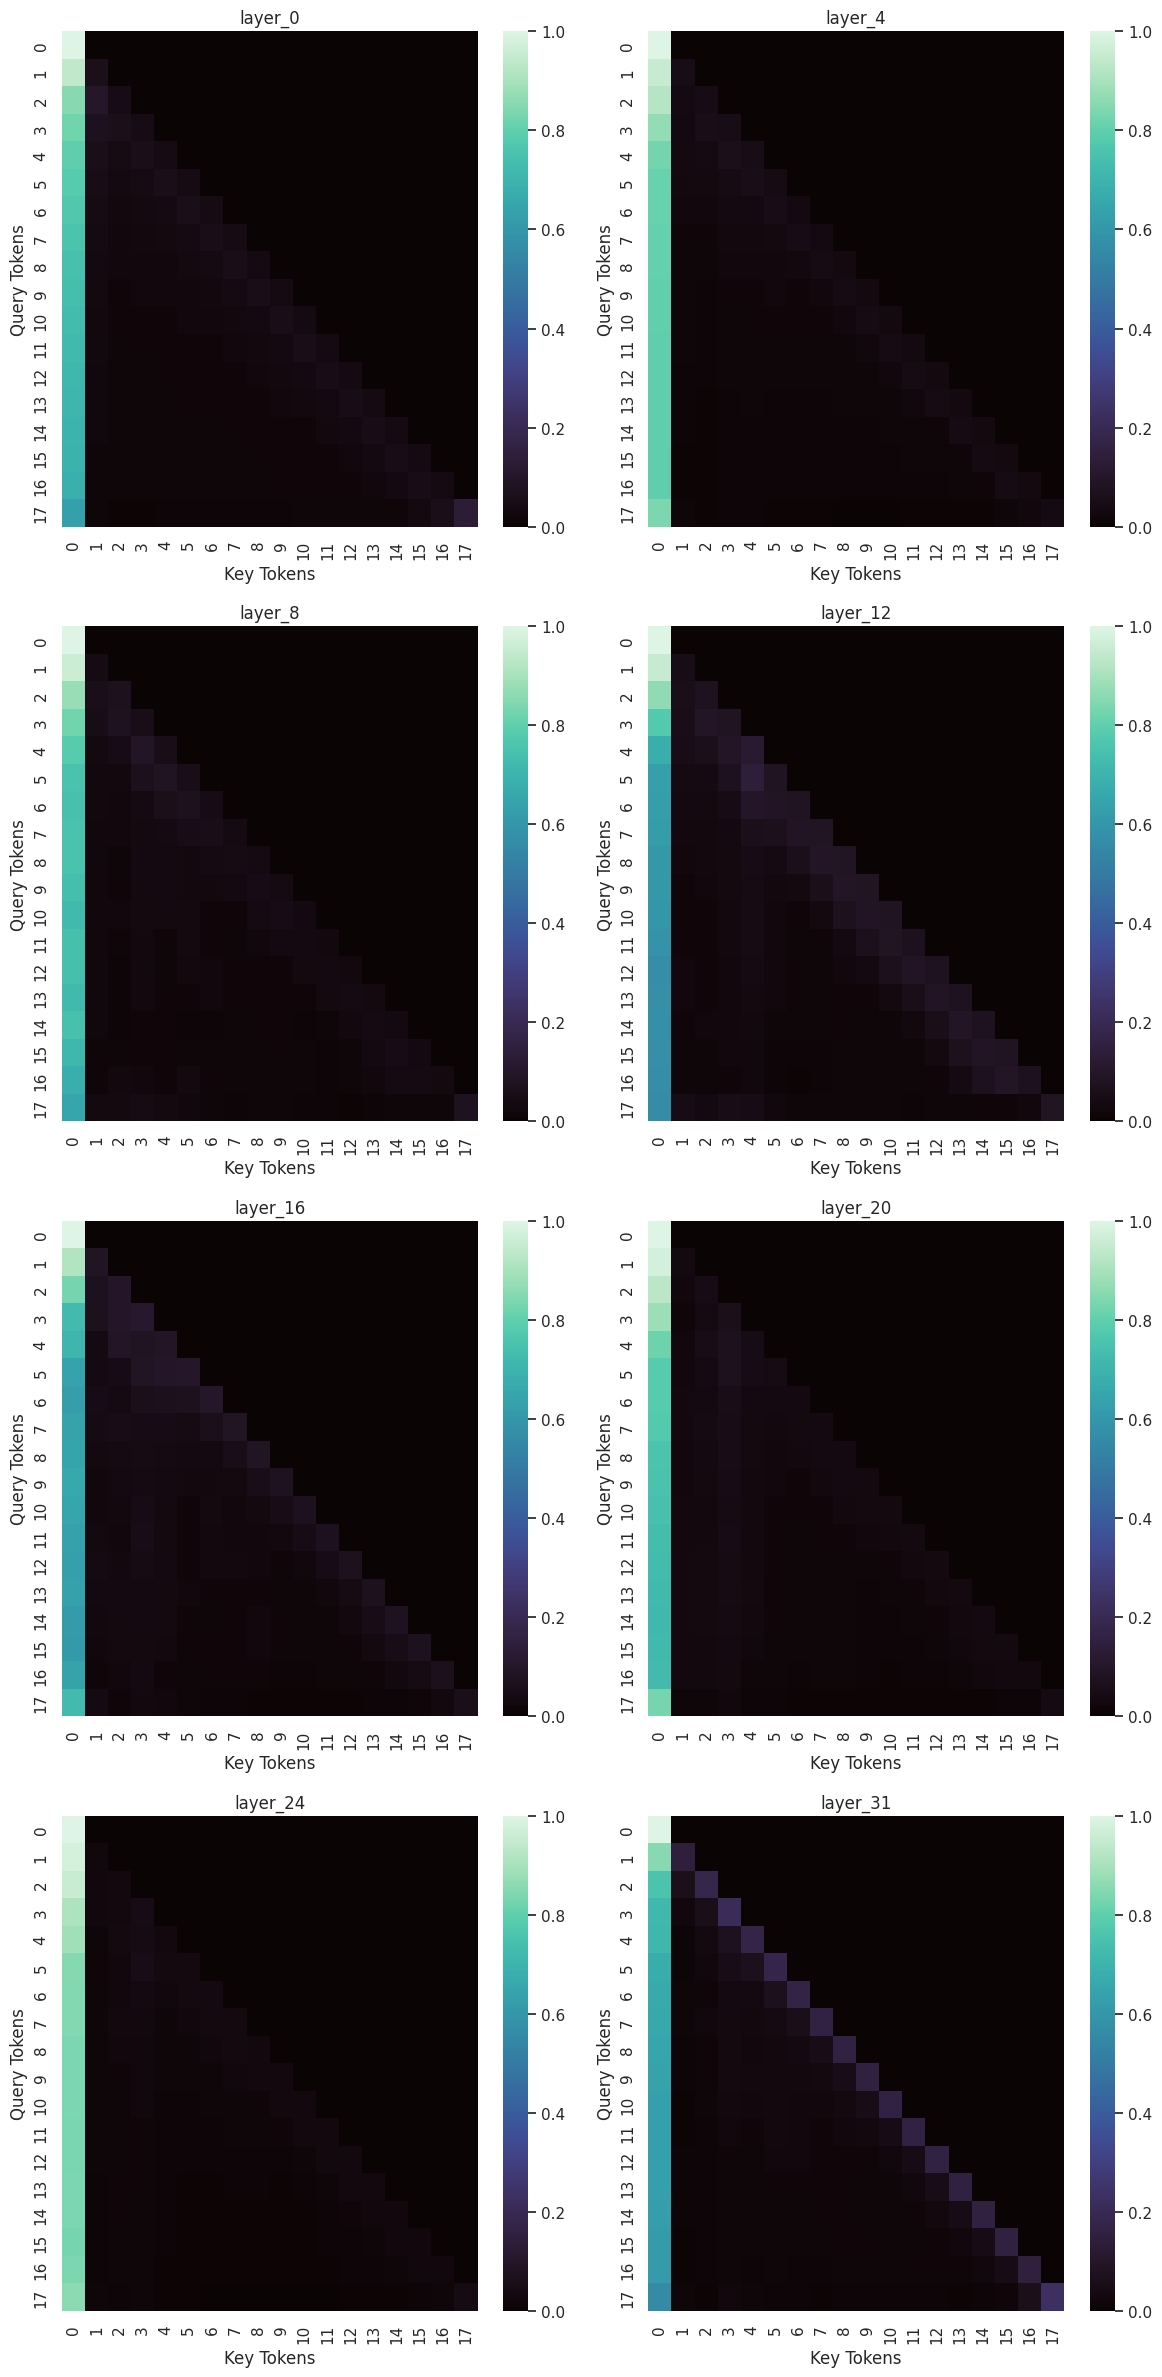


--- Processing input: short_meaningful ---


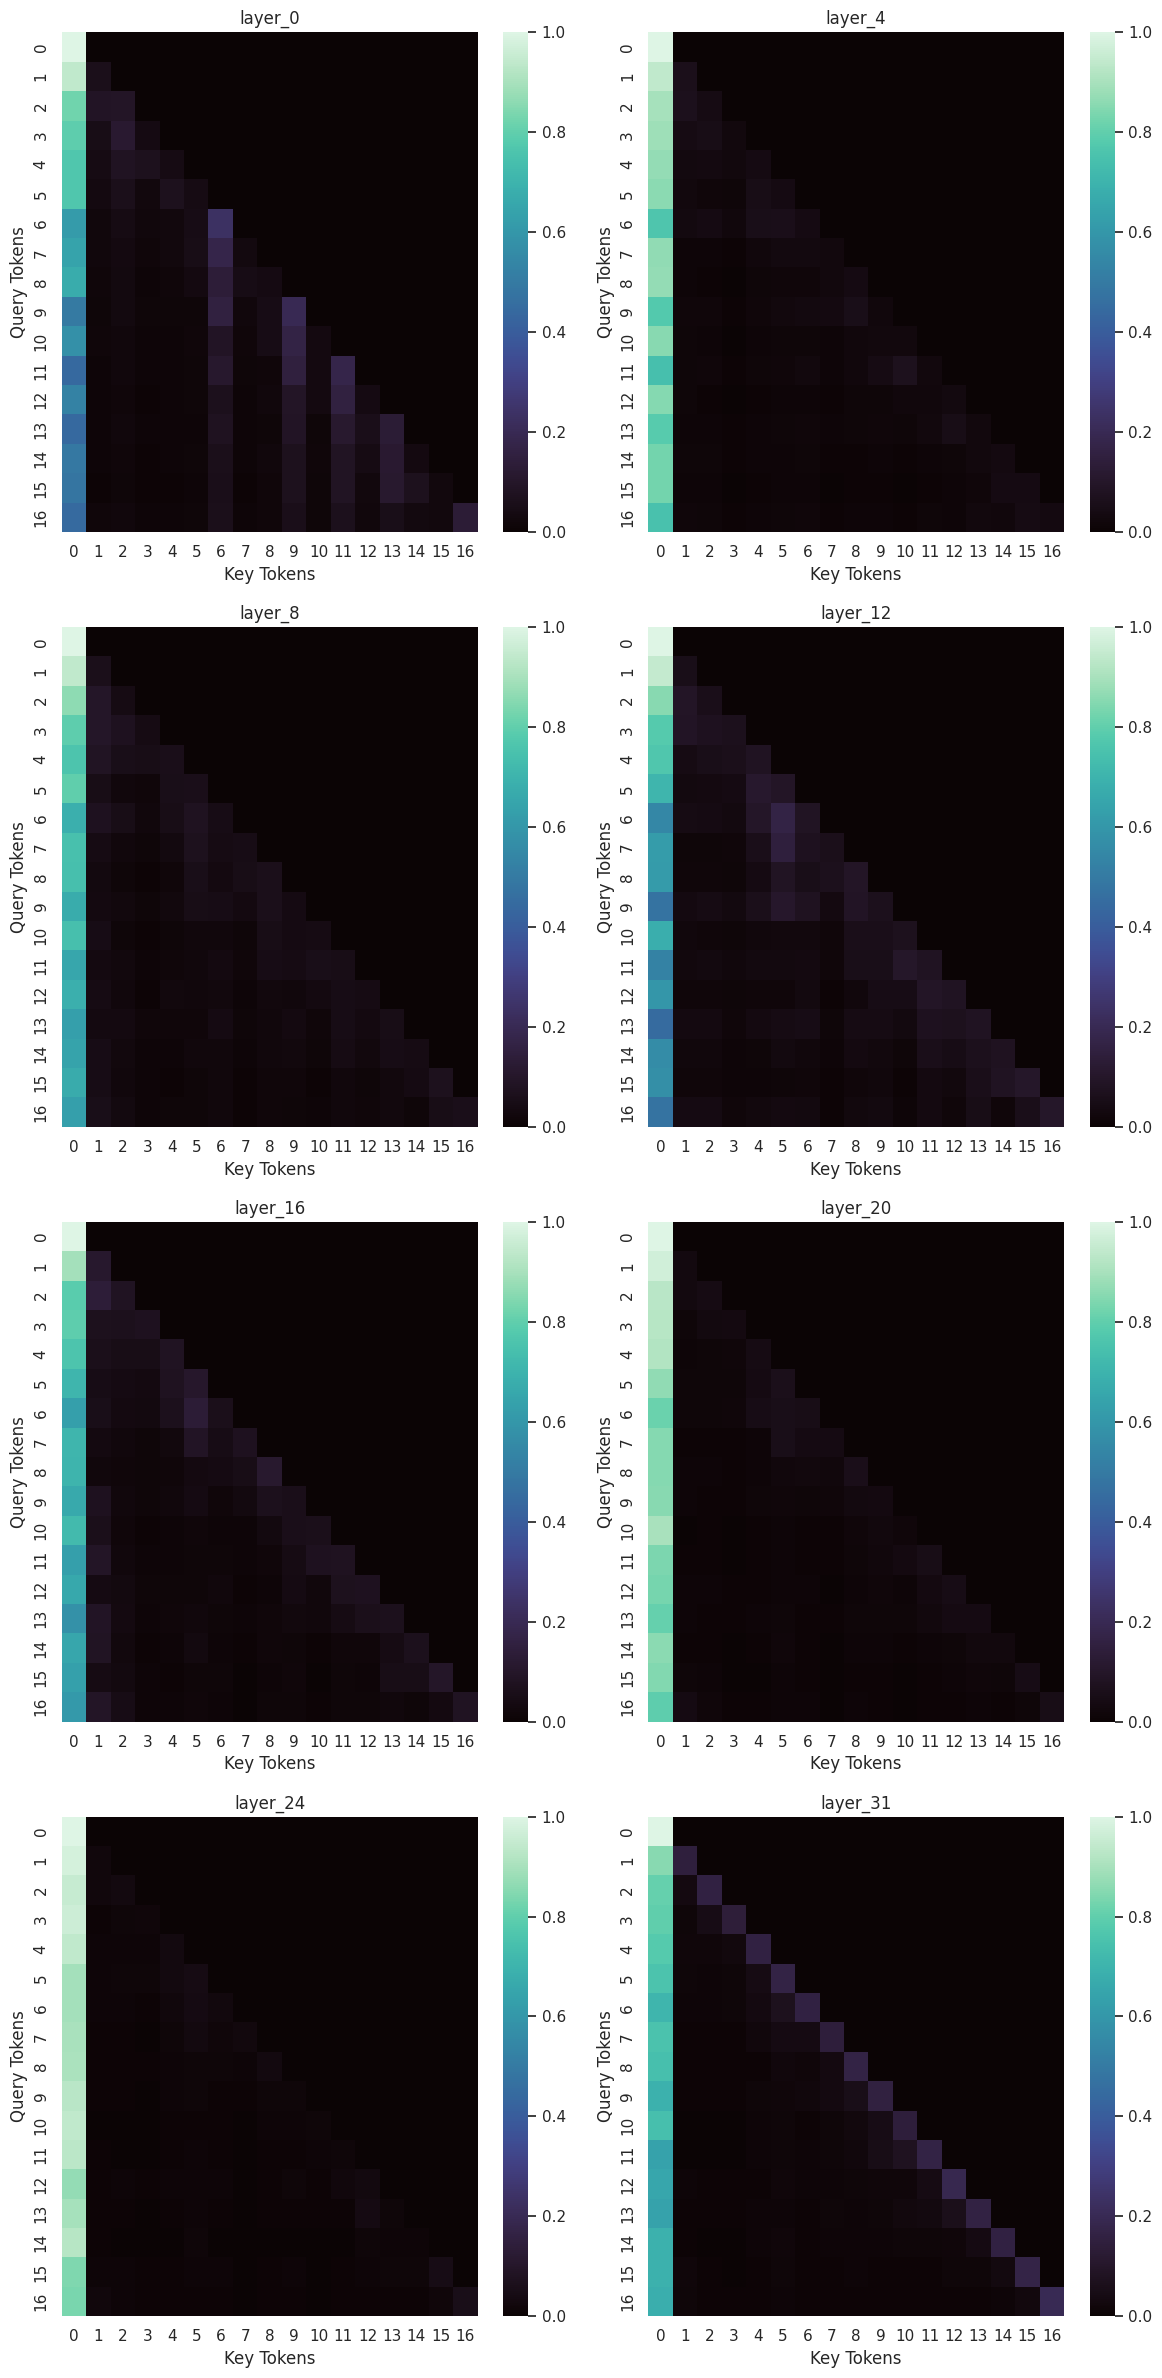


--- Processing input: medium_dummy ---


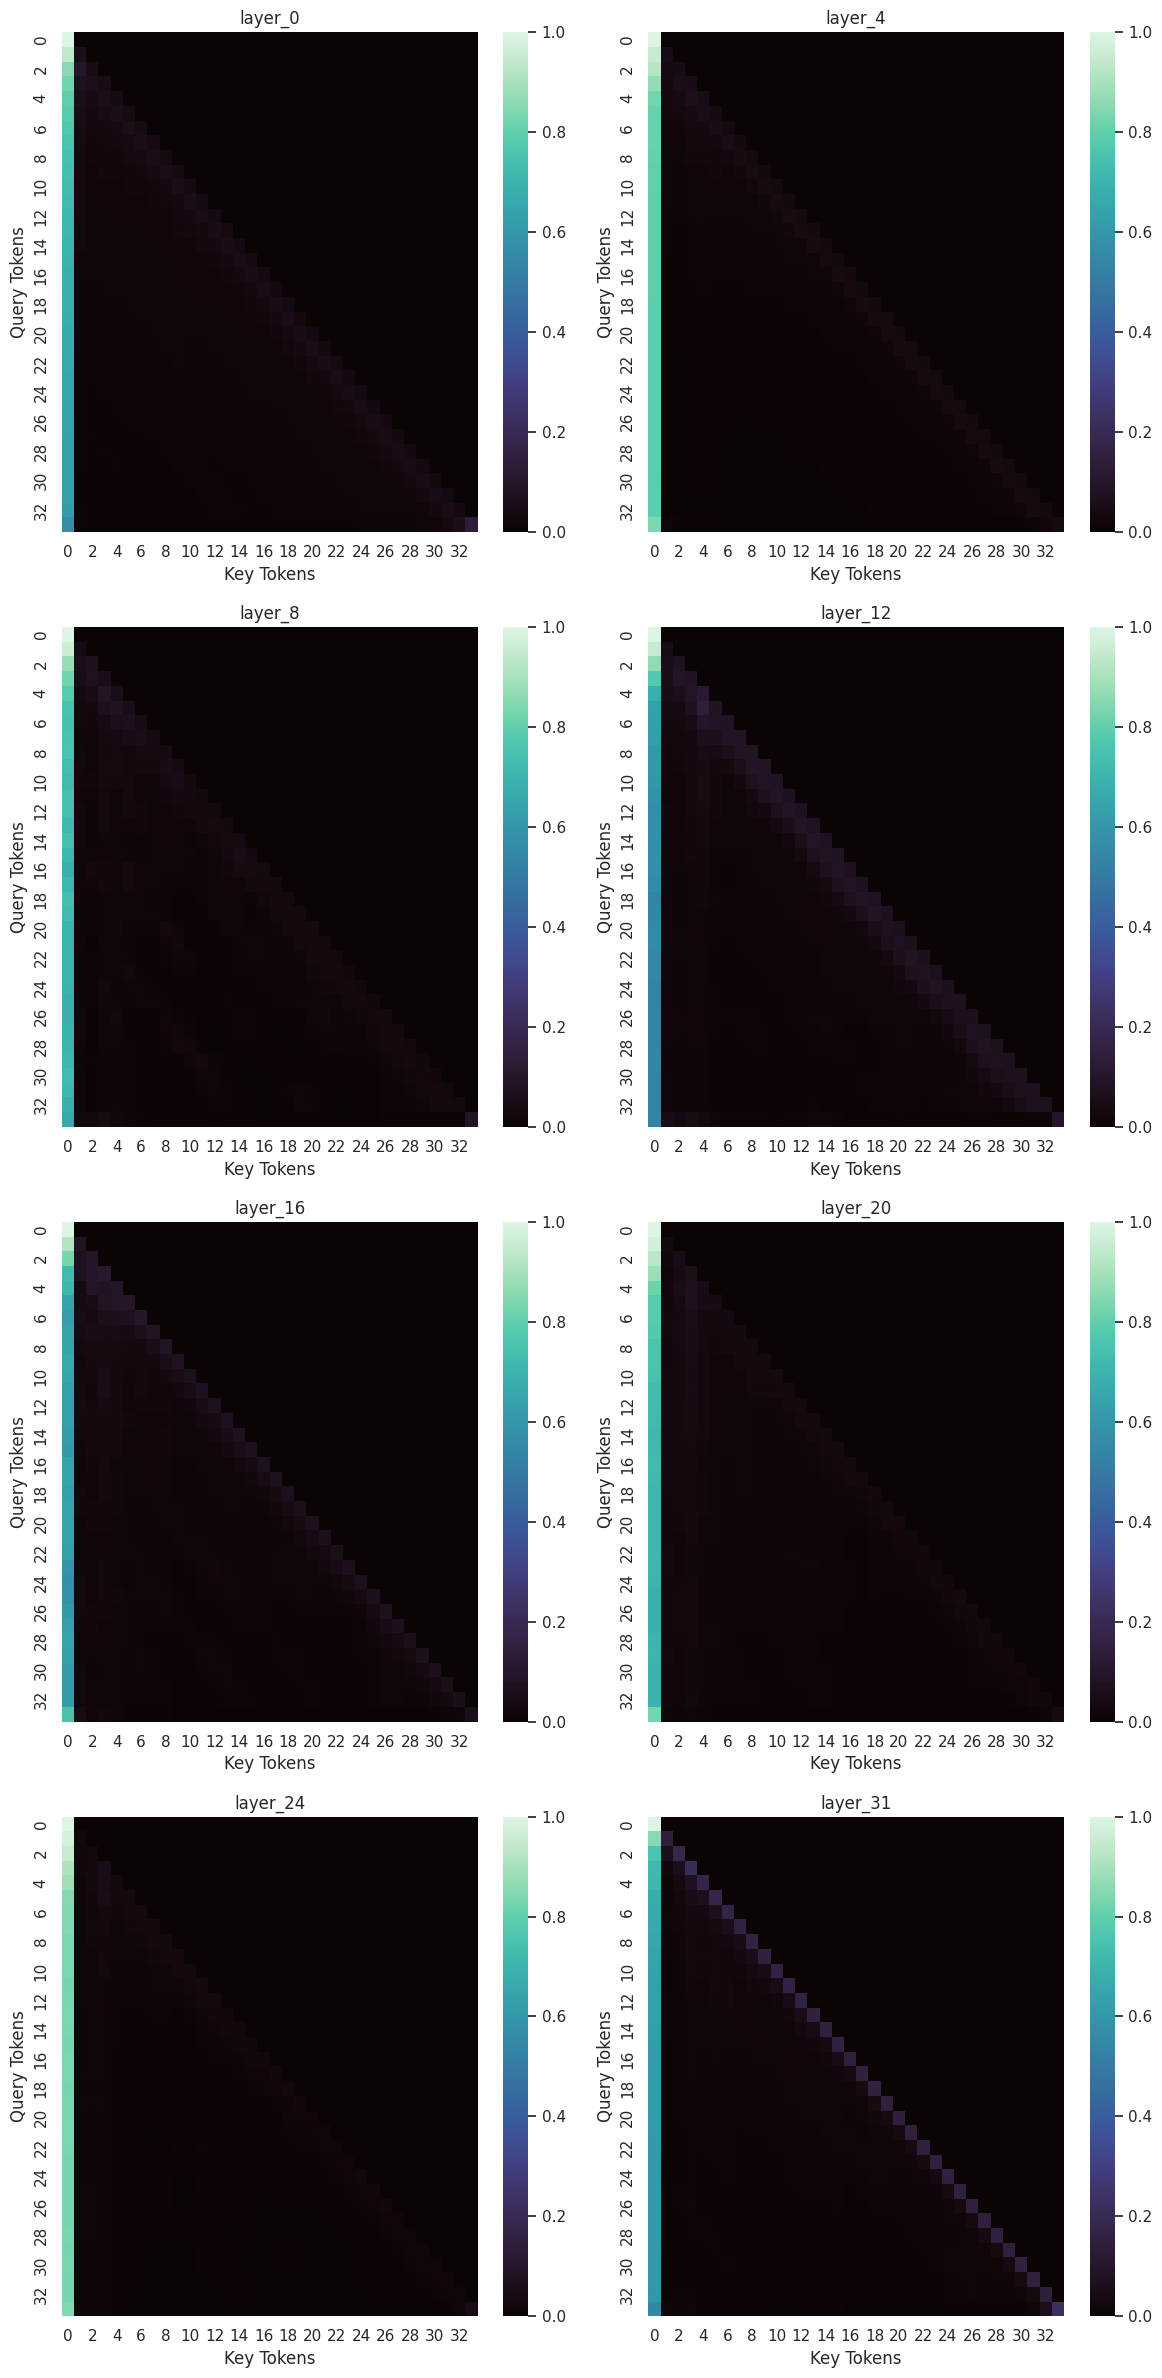


--- Processing input: medium_meaningful ---


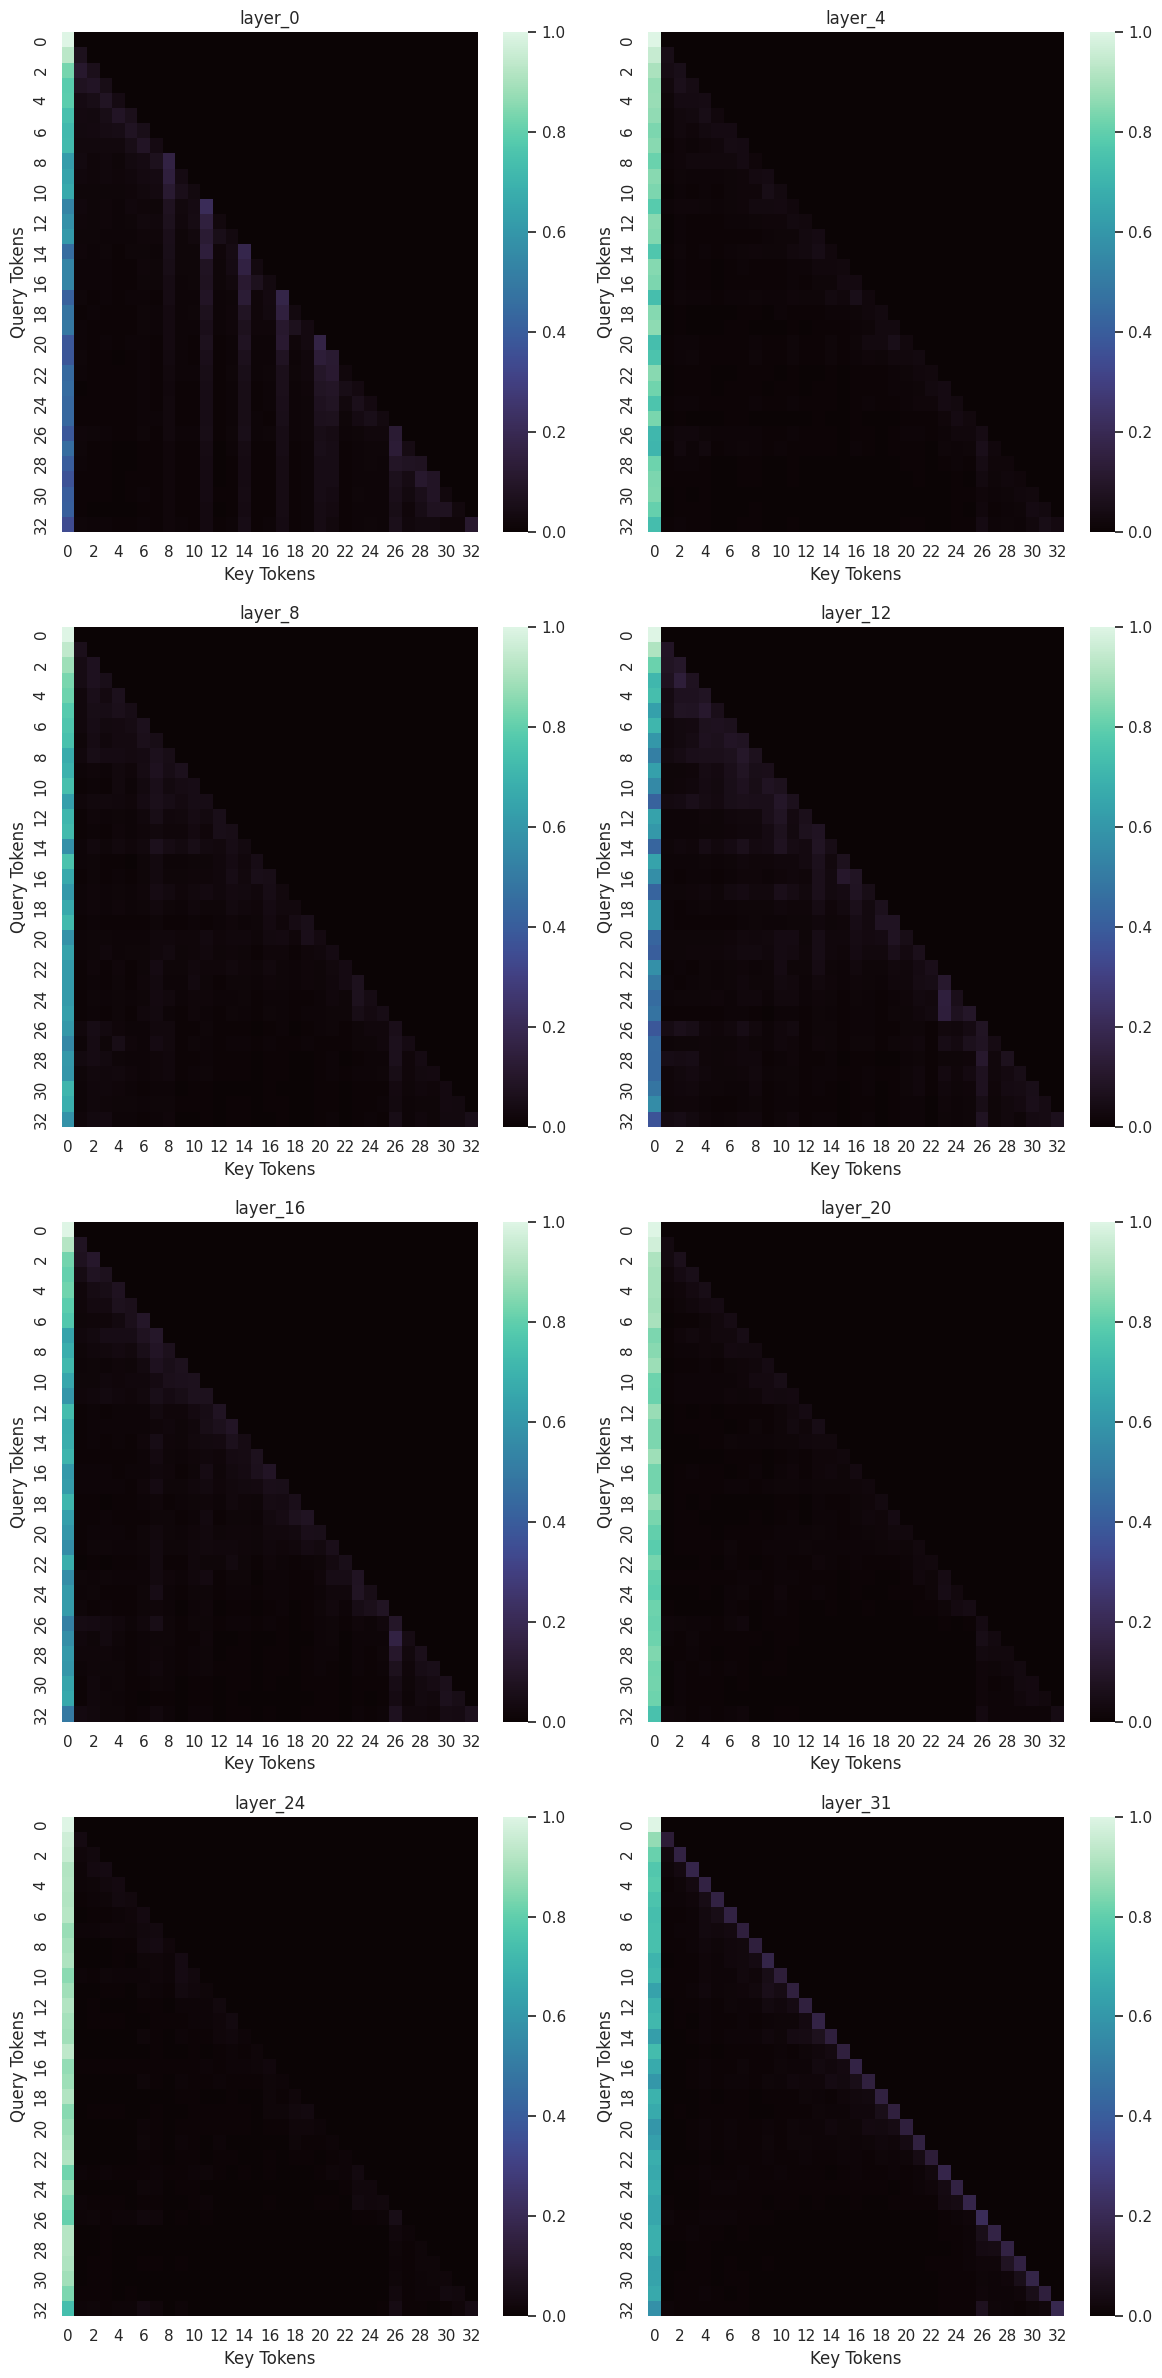


--- Processing input: long_dummy ---


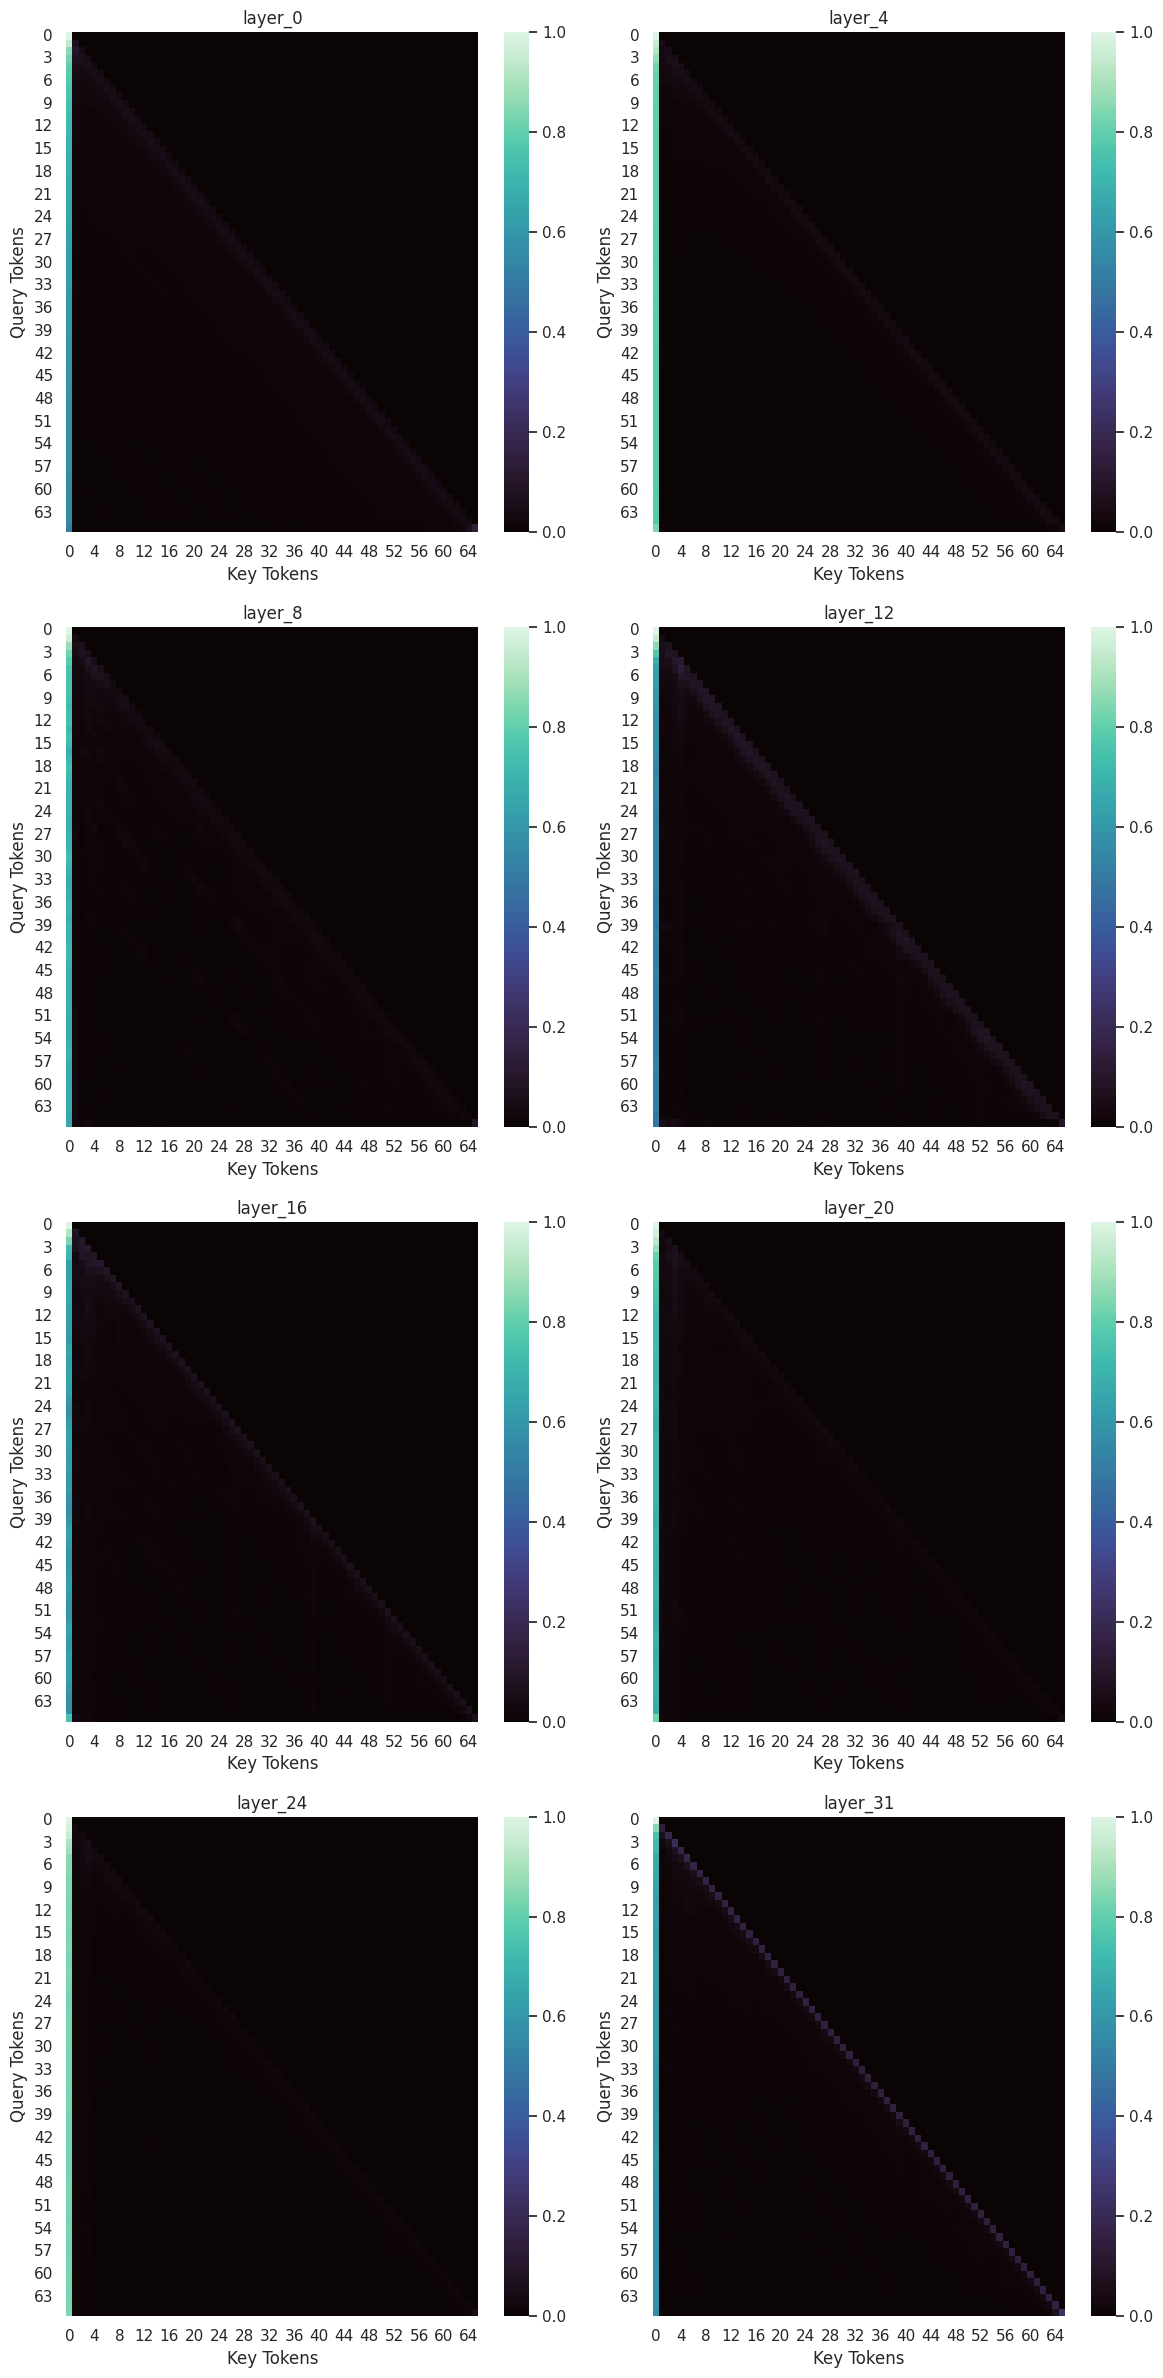


--- Processing input: long_meaningful ---


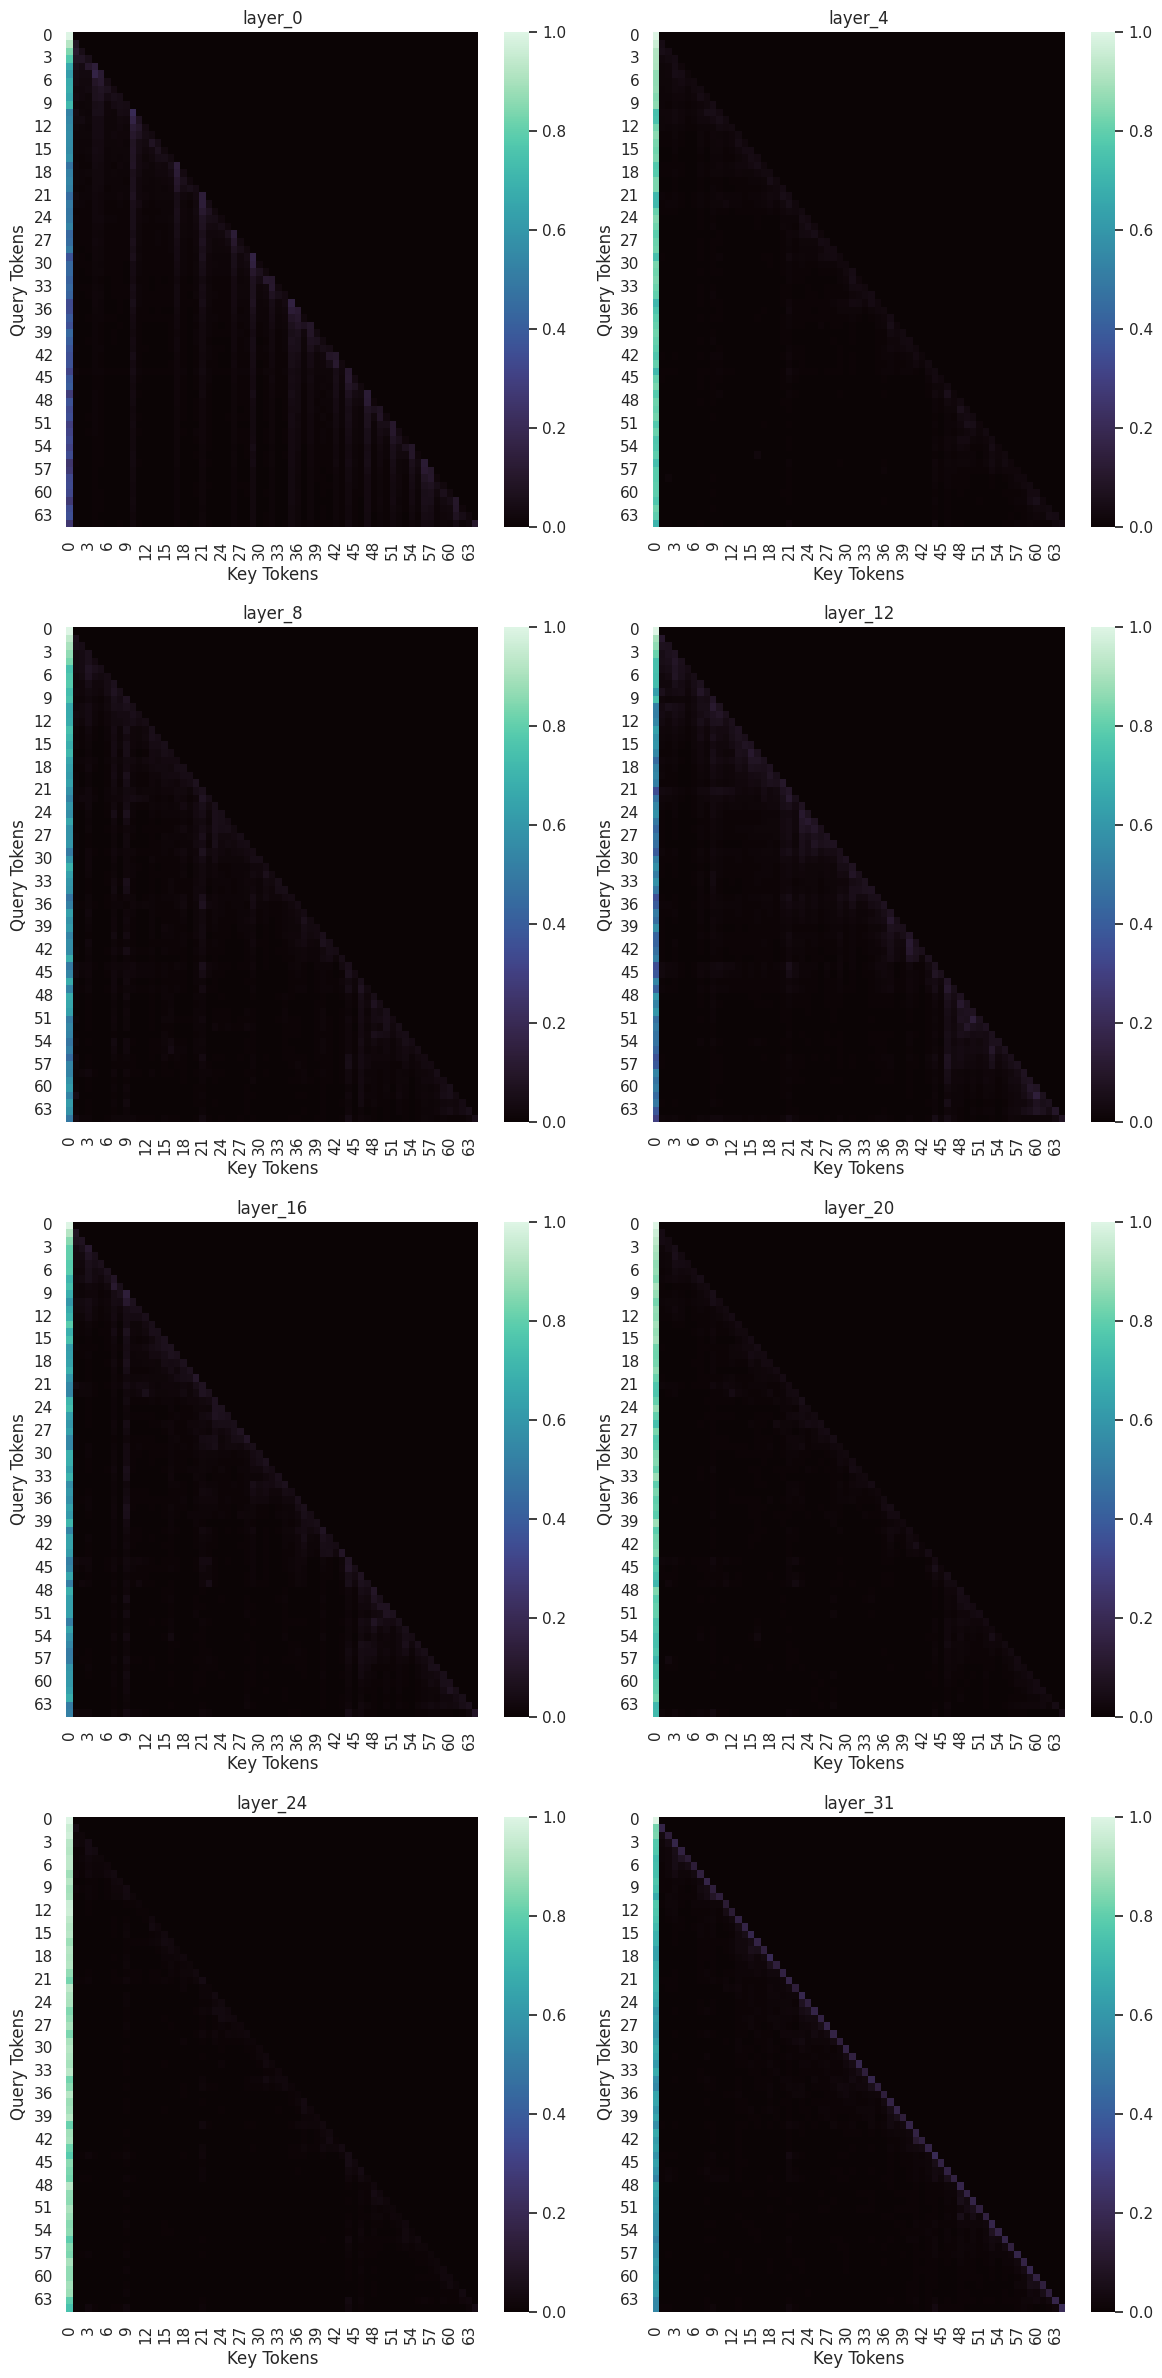


   All attention maps for the provided inputs have been generated.


In [18]:
### Cell 6: Experiment - Visualize Attention Maps for Different Inputs

INPUT_TEXTS = {
    "short_dummy": "tik " * 16,
    "short_meaningful": "Paris has very old streets, small cafes, art, history and beautiful nights.",
    "medium_dummy": "tik " * 32,
    "medium_meaningful": "Many travelers enjoy walking through historic cities with busy streets, local cafes, art markets, street music, and small parks near buildings. It is a fun time.",
    "long_dummy": "tik " * 64,
    "long_meaningful": "When people travel to a new city like Paris, they often walk through quiet streets and visit small museums. They eat local food in cozy cafes, take photos of old buildings, and relax in public parks during the afternoon. At night, lights from shops and restaurants fill the streets, and people enjoy music and warm conversation."
}

LAYERS_TO_VISUALIZE = [0, 4, 8, 12, 16, 20, 24, 31]
if "1b" in MODEL_ID.lower():
    LAYERS_TO_VISUALIZE = [0, 1, 2, 3, 4, 5, 6, 7]

hooks = register_attention_hooks(model, LAYERS_TO_VISUALIZE)

for name, text in INPUT_TEXTS.items():
    print(f"\n--- Processing input: {name} ---")
    attention_maps_storage.clear()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256).to(DEVICE)
    with torch.no_grad():
        _ = model(**inputs, output_attentions=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    plot_attention_maps(attention_maps_storage, tokens, LAYERS_TO_VISUALIZE, f"task2_step2__{name}")

for handle in hooks:
    handle.remove()

print("\n   All attention maps for the provided inputs have been generated.")


--- Starting Experiment: Attention Sink Phenomenon Analysis ---

--- Attention Sink Analysis Results ---
          Input Type  Sink Attention (%)
0         long_dummy           72.127016
1    long_meaningful           68.596311
2       medium_dummy           75.364583
3  medium_meaningful           73.006466
4        short_dummy           79.352679
5   short_meaningful           77.764423


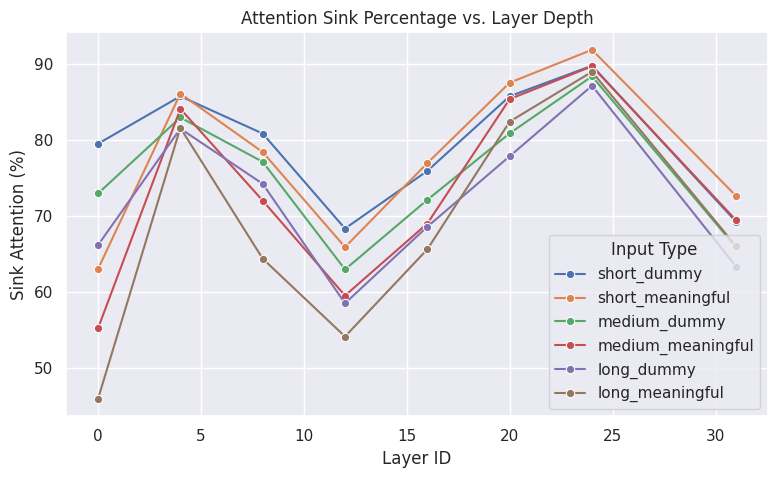

In [20]:
### Cell 7: Experiment - Attention Sink Phenomenon Analysis

print("\n--- Starting Experiment: Attention Sink Phenomenon Analysis ---")
# --- Configurable Section ---
SINK_TOKEN_WINDOW = 4  # TODO: choose number of initial tokens treated as sink tokens
# ---

sink_analysis_results = []
hooks = []
hooks = register_attention_hooks(model, range(model.config.num_hidden_layers))

for name, text in INPUT_TEXTS.items():
    attention_maps_storage.clear()
    inputs = tokenizer(text, return_tensors="pt", max_length=256).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    for layer_idx in range(model.config.num_hidden_layers):
        layer_name = f"layer_{layer_idx}"
        if layer_name in attention_maps_storage:
            attn_map = attention_maps_storage[layer_name][0].mean(dim=0)
            sink_attention_strength = attn_map[SINK_TOKEN_WINDOW:, :SINK_TOKEN_WINDOW].sum().item()
            total_attention = attn_map[SINK_TOKEN_WINDOW:, :].sum().item()
            sink_percentage = (sink_attention_strength / total_attention) * 100 if total_attention > 0 else 0
            sink_analysis_results.append({"Input Type": name, "Layer ID": layer_idx, "Sink Attention (%)": sink_percentage})

for handle in hooks:
    handle.remove()

df_sink = pd.DataFrame(sink_analysis_results)
df_sink.to_csv(f"{RESULTS_DIR}/task2_step3__sink.csv", index=False)

# TODO: plot sink attention percentage vs. layer depth for each input type
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_sink,
    x="Layer ID",
    y="Sink Attention (%)",
    hue="Input Type",
    marker="o"
)
plt.title("Attention Sink Percentage vs. Layer Depth")
plt.xlabel("Layer ID")
plt.ylabel("Sink Attention (%)")
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/task2_step3__sink.png", dpi=300)

print("\n--- Attention Sink Analysis Results ---")
print(df_sink.groupby("Input Type")["Sink Attention (%)"].mean().reset_index())
plt.show()


#### Attention Sink Phenomenon Analysis

**Observed Phenomena:**

**Analysis:**

In [ ]:
### Cell 8: Bonus Experiment: Modify Standard Attention to StreamingLLM Attention (Task 2 Step 4)
# TODO: import required modules for custom attention (transformers attention utilities, logging, torch.nn, types)
# from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS
# from transformers.models.llama.modeling_llama import LlamaAttention, rotate_half, repeat_kv
# from transformers.utils import logging
# import torch.nn as nn
# import types


def eager_attention_forward(
    module: nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    """
    Implements the standard (eager) attention forward pass.
    """
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    attn_weights = nn.functional.softmax(
        attn_weights, dim=-1, dtype=torch.float32
    ).to(query.dtype)
    attn_weights = nn.functional.dropout(
        attn_weights, p=dropout, training=module.training
    )
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights

def apply_rotary_pos_emb_single(x, cos, sin, position_ids):
    """
    Applies rotary positional embedding to a single tensor.
    """
    # Remove singleton dimensions for broadcasting
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed

def apply_rotary_pos_emb_q(q, cos, sin, unsqueeze_dim=1):
    """
    Applies rotary positional embedding to the query tensor.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    return q_embed


# TODO: refer to https://github.com/mit-han-lab/streaming-llm/blob/main/streaming_llm/pos_shift/modify_llama.py
# modify to fit llama3 architecture
def llama_pos_shift_attention_forward(self, hidden_states, position_embeddings, attention_mask, past_key_value, cache_position=None, **kwargs):
    """Modified LLaMA attention forward pass with position shifting for StreamLLM."""
    # TODO: project QKV, update caches, apply rotary embeddings, and compute attention outputs
    ...

def enable_llama_pos_shift_attention(model):
    """Replace standard LlamaAttention.forward methods with the position-shifted variant."""
    # TODO: recursively locate LlamaAttention modules and bind llama_pos_shift_attention_forward
    ...


In [ ]:
### Cell 9: Bonus Experiment: Investigate StreamLLM's Impact on Long-Sequence Memory Usage
# TODO: import tqdm for progress visualisation
# from tqdm.auto import tqdm

print("\n--- Starting Bonus Experiment: Simulating StreamLLM Memory Impact ---")

# --- Configurable Section ---
BONUS_PROMPT = "..."  # TODO: provide long-form prompt
BONUS_GENERATION_LENGTH = ...  # TODO: choose number of tokens to generate
BONUS_SAMPLING_INTERVAL = ...  # TODO: sampling interval for memory measurements
STREAMLLM_CACHE_SIZE = ...  # TODO: number of sink tokens to retain
STREAMLLM_RECENT_SIZE = ...  # TODO: number of most recent tokens to retain
# ---

def run_baseline_experiment(model, tokenizer, prompt, generation_length, sampling_interval, device):
    """Run baseline generation with the standard KV cache while logging memory usage."""
    # TODO: implement generation loop without cache eviction and record GPU memory
    ...

class streamingllm_kv:
    """Implement StreamLLM-style KV cache eviction (retain sink + recent tokens)."""
    def __init__(self, start_size, recent_size, past_key_values):
        # TODO: store configuration for cache trimming
        ...

    def __call__(self, kv_cache):
        """Trim the KV cache according to the StreamLLM policy."""
        # TODO: drop middle tokens while retaining sink and recent tokens
        ...

def run_streamllm_experiment(model, tokenizer, prompt, generation_length, sampling_interval, sink_size, recent_size, device):
    """Run generation with StreamLLM cache eviction and record memory usage."""
    # TODO: enable modified attention, apply streaming cache policy, and log memory
    ...

# =================================================================================
# Main Execution Flow
# =================================================================================

# TODO: prepare chat-formatted prompt and run both baseline and StreamLLM experiments
# messages = [...]
# BONUS_PROMPT = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# memory_baseline, last100words_baseline = run_baseline_experiment(...)
# memory_streamllm, last100words_streamllm = run_streamllm_experiment(...)

# TODO: collate memory usage results, save CSV artifacts, and plot comparisons
# df_mem_compare = pd.concat([...])
# df_mem_compare.to_csv("./results/task2_bonus_memory_comparison.csv", index=False)
# sns.lineplot(...)
# plt.savefig("./figures/task2_bonus_memory_comparison.png", dpi=300)

# TODO: decode and print the final segments from each generation for qualitative comparison
# print(tokenizer.decode(last100words_baseline))
# print(tokenizer.decode(last100words_streamllm))


In [21]:
### Cell 10: List all generated artifacts for Task 2
print("Task 2 complete. Generated artifacts:")

if os.path.isdir(RESULTS_DIR):
    print(f"\nFiles in {RESULTS_DIR}:")
    for filename in os.listdir(RESULTS_DIR):
        print(f"- {filename}")

if os.path.isdir(FIGURES_DIR):
    print(f"\nFiles in {FIGURES_DIR}:")
    for filename in os.listdir(FIGURES_DIR):
        print(f"- {filename}")


Task 2 complete. Generated artifacts:

Files in ./results:
- task2_step3__sink.csv
- .gitkeep
- task1_step2__full.csv
- task1_step2__summary.csv
- task1_step5__memory.csv

Files in ./figures:
- .gitkeep
- task2_step2__medium_dummy.png
- task2_step3__sink.png
- task1_step3__latency.png
- task1_step5__memory.png
- task2_step2__medium_meaningful.png
- task2_step2__long_dummy.png
- task2_step2__long_meaningful.png
- task2_step2__short_dummy.png
- task2_step2__short_meaningful.png
